In [1]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf


from sklearn.preprocessing import MinMaxScaler
from collections import deque
from sklearn.metrics import r2_score


from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import seaborn as sns
import matplotlib.pyplot as plt

# Prepare Data

In [1]:
LOOKUP_STEPS = [1]

In [4]:
ds_path = '/content/drive/MyDrive/NN_CW_DATASETS/ETHUSDT_rsi_fagi_12.csv'
df_ethereum = pd.read_csv(ds_path)

df_ethereum

,Date,Open,High,Low,Close,Volume,Close_time,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume,Cryptoname,FAGI,RSI,MA_50,ROC_26
0,2021-01-29,1330.28,1443.00,1285.46,1381.99,5010264.423,2021-01-30,6.852570e+09,3646547,2406600.666,3.291810e+09,ETHUSDT,77,60.353563,960.8900,40.984861
1,2021-01-30,1382.14,1409.35,1328.00,1380.48,2364036.673,2021-01-31,3.218442e+09,2016654,1159814.103,1.579703e+09,ETHUSDT,76,60.259100,977.6048,32.342706
2,2021-01-31,1380.42,1383.70,1281.96,1313.12,2091898.285,2021-02-01,2.789247e+09,1745459,980938.920,1.307931e+09,ETHUSDT,78,56.044996,992.5004,19.234716
3,2021-02-01,1313.09,1379.73,1270.00,1376.48,2282184.993,2021-02-02,3.023615e+09,1841919,1133593.179,1.502912e+09,ETHUSDT,77,58.952792,1008.2118,13.511017
4,2021-02-02,1376.74,1551.50,1363.00,1516.26,5098356.241,2021-02-03,7.431221e+09,3355992,2499526.773,3.644008e+09,ETHUSDT,76,64.527942,1026.8104,23.562488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,2023-09-02,1628.20,1644.99,1627.05,1636.24,754625.922,2023-09-03,1.233124e+09,779308,368608.693,6.023791e+08,ETHUSDT,39,36.904590,1794.4530,-10.498966
947,2023-09-03,1636.24,1648.24,1623.93,1635.02,838943.974,2023-09-04,1.371256e+09,794257,428801.493,7.010036e+08,ETHUSDT,40,36.756482,1788.5454,-11.875862
948,2023-09-04,1635.03,1644.50,1614.76,1630.09,1087824.165,2023-09-05,1.772994e+09,1049704,544060.418,8.867962e+08,ETHUSDT,40,36.125549,1782.7278,-12.110314
949,2023-09-05,1630.08,1648.00,1608.45,1633.63,1444381.953,2023-09-06,2.353454e+09,1320230,723388.438,1.178788e+09,ETHUSDT,40,36.962290,1777.1930,-11.763403


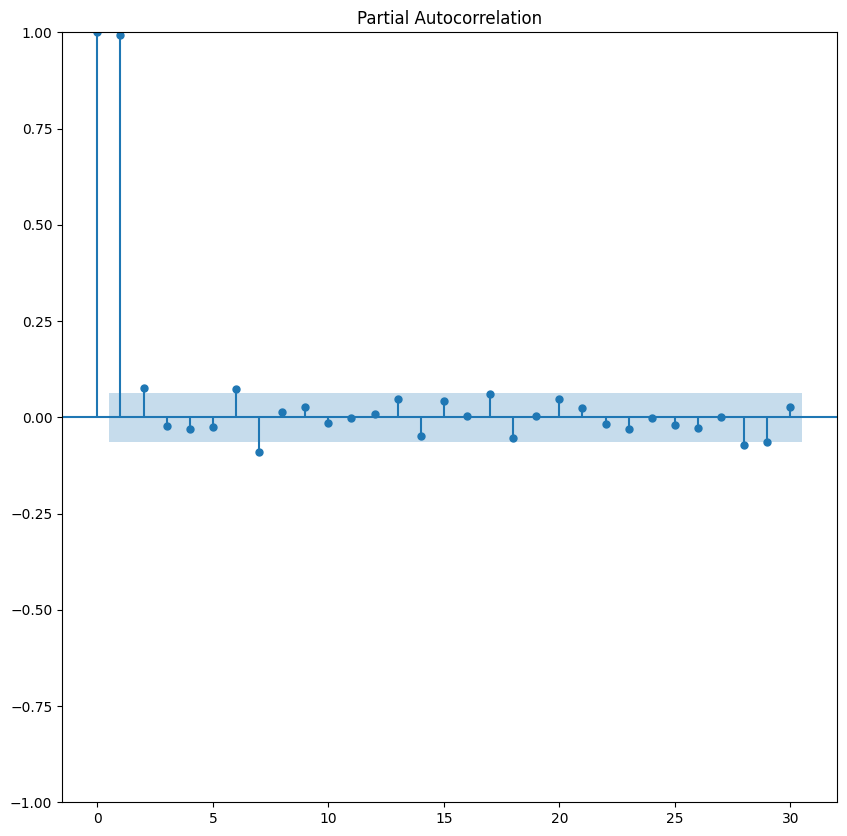

In [4]:
close_price = df_ethereum['Close']

fig, ax = plt.subplots(figsize=(10,10))
plot_pacf(close_price, ax=ax)
plt.show()

In [ ]:
# temp_df = df_ethereum.drop(['Date', 'Close_time', 'Cryptoname'], axis=1)
# correlation_matrix = temp_df.corr()

# plt.figure(figsize=(8, 8))
# sns.heatmap(correlation_matrix, annot=True)
# plt.show()

In [4]:
df_ethereum = df_ethereum[['Date', 'Open', 'Close', 'High', 'Low', 'RSI', 'FAGI', 'MA_50', 'ROC_26']]

# df_ethereum = df_ethereum[['Date', 'Open', 'Close', 'High', 'Low', 'RSI', 'FAGI']]

df_ethereum

KeyError: "['MA_50', 'ROC_26'] not in index"

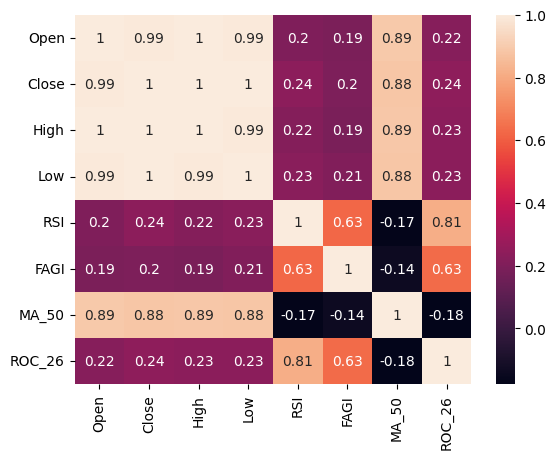

In [6]:
temp_df = df_ethereum.drop(['Date'], axis=1)
correlation_matrix = temp_df.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

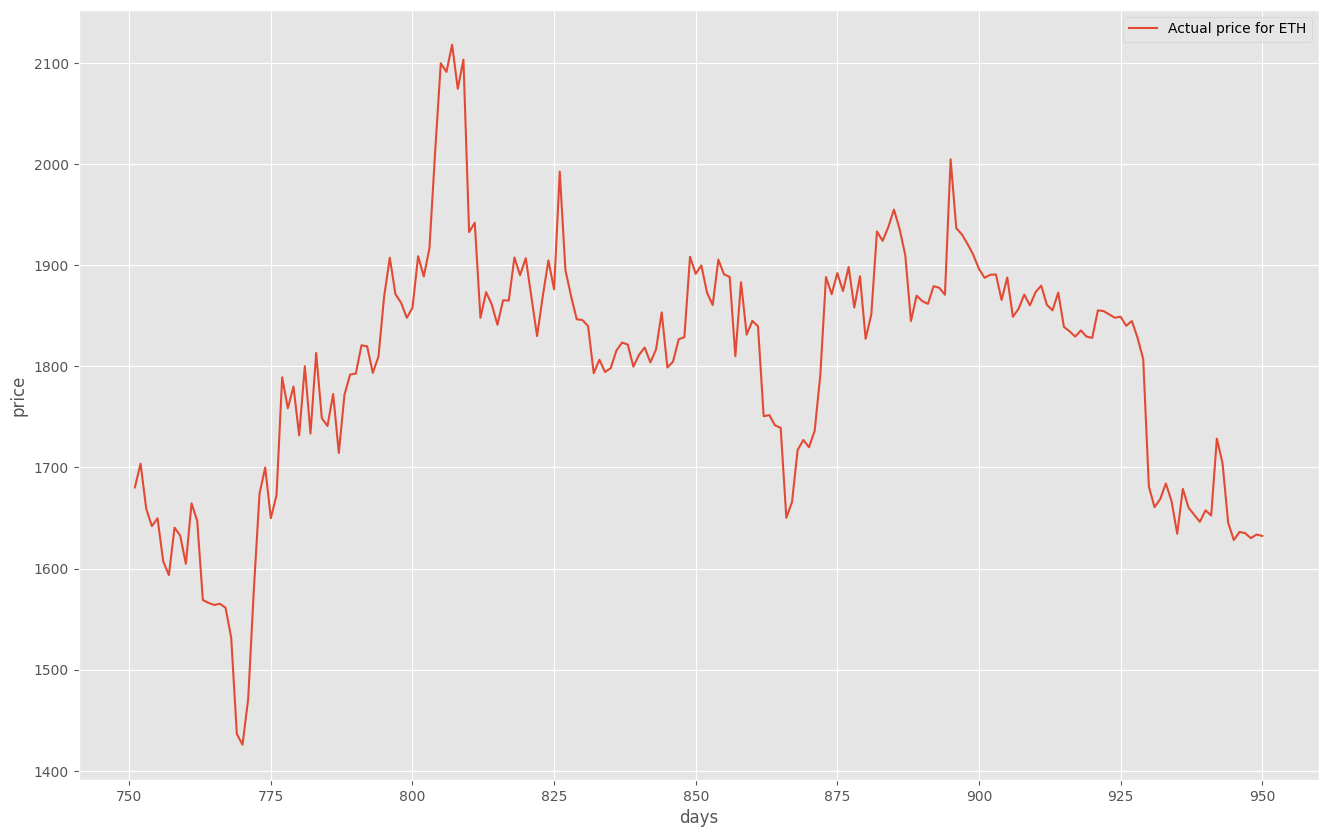

In [5]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(df_ethereum['Close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for ETH'])
plt.show()

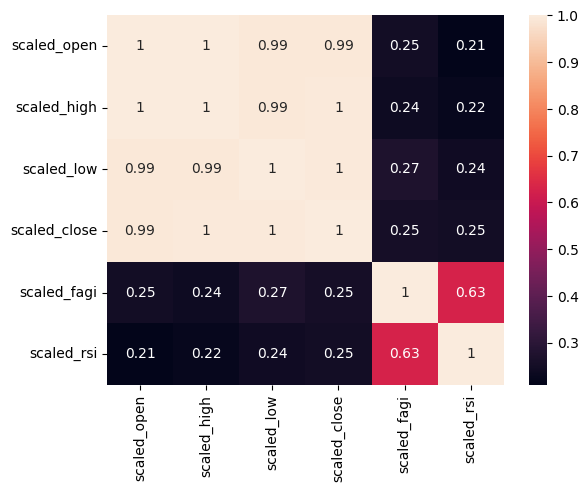

In [60]:
temp_df = df_ethereum.drop(['Date', 'Open', 'Close', 'High', 'Low', 'RSI', 'FAGI'], axis=1)
correlation_matrix = temp_df.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [7]:
input_lag = 14

# Predict

In [ ]:
data_scaler = MinMaxScaler()
data_scaler.fit(df_ethereum[['Open', 'High', 'Low']])
df_ethereum[['scaled_open', 'scaled_high', 'scaled_low']] = data_scaler.transform(df_ethereum[['Open', 'High', 'Low']])

close_scaler = MinMaxScaler()
close_scaler.fit(df_ethereum[['Close']])
df_ethereum[['scaled_close']] = close_scaler.transform(df_ethereum[['Close']])

feature_scaler = MinMaxScaler()
feature_scaler.fit(df_ethereum[['FAGI', 'RSI']])
df_ethereum[['scaled_fagi', 'scaled_rsi']] = feature_scaler.transform(df_ethereum[['FAGI', 'RSI']])

In [9]:
df_ethereum

,Date,Open,Close,High,Low,RSI,FAGI,MA_50,ROC_26,scaled_open,scaled_high,scaled_low,scaled_close,scaled_fagi,scaled_rsi
0,2021-01-29,1330.28,1381.99,1443.00,1285.46,60.353563,77,960.8900,40.984861,0.088007,0.095831,0.106188,0.101539,0.797753,0.611265
1,2021-01-30,1382.14,1380.48,1409.35,1328.00,60.259100,76,977.6048,32.342706,0.101583,0.086972,0.117275,0.101144,0.786517,0.609852
2,2021-01-31,1380.42,1313.12,1383.70,1281.96,56.044996,78,992.5004,19.234716,0.101132,0.080220,0.105276,0.083511,0.808989,0.546820
3,2021-02-01,1313.09,1376.48,1379.73,1270.00,58.952792,77,1008.2118,13.511017,0.083507,0.079175,0.102158,0.100097,0.797753,0.590313
4,2021-02-02,1376.74,1516.26,1551.50,1363.00,64.527942,76,1026.8104,23.562488,0.100169,0.124395,0.126397,0.136686,0.786517,0.673703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,2023-09-02,1628.20,1636.24,1644.99,1627.05,36.904590,39,1794.4530,-10.498966,0.165996,0.149006,0.195218,0.168093,0.370787,0.260531
947,2023-09-03,1636.24,1635.02,1648.24,1623.93,36.756482,40,1788.5454,-11.875862,0.168100,0.149862,0.194405,0.167773,0.382022,0.258316
948,2023-09-04,1635.03,1630.09,1644.50,1614.76,36.125549,40,1782.7278,-12.110314,0.167784,0.148877,0.192015,0.166483,0.382022,0.248879
949,2023-09-05,1630.08,1633.63,1648.00,1608.45,36.962290,40,1777.1930,-11.763403,0.166488,0.149799,0.190370,0.167410,0.382022,0.261394


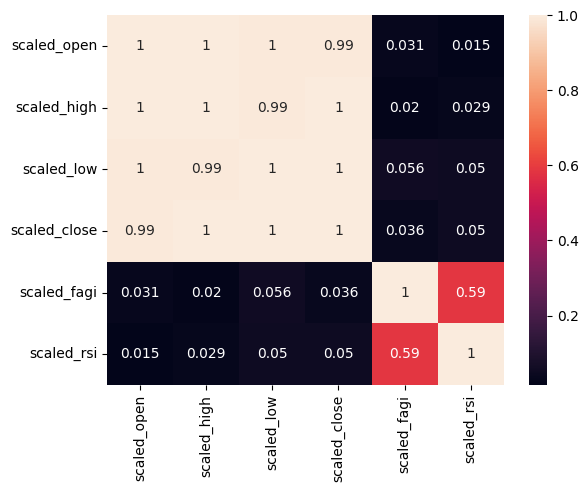

In [67]:
temp_df = df_ethereum.drop(['Date', 'Open', 'Close', 'High', 'Low', 'RSI', 'FAGI'], axis=1)
correlation_matrix = temp_df.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [10]:
def PrepareDataPredict(days):
  df = df_ethereum.copy()
  df['target'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close', 'scaled_open', 'scaled_high', 'scaled_low', 'scaled_rsi', 'scaled_fagi']].tail(days))
  df.dropna(inplace=True)

  data_for_sequences = []
  sequences = deque(maxlen=input_lag)

  for entry, target in zip(df[['scaled_close', 'scaled_open', 'scaled_high', 'scaled_low', 'scaled_rsi', 'scaled_fagi']].values, df['target'].values):
    sequences.append(entry)
    if len(sequences) == input_lag:
        data_for_sequences.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close', 'scaled_open', 'scaled_high', 'scaled_low', 'scaled_rsi', 'scaled_fagi'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  X, Y = [], []
  for seq, target in data_for_sequences:
      X.append(seq)
      Y.append(target)

  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [11]:
def GetTrainedModelPredict(x_train, y_train):
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(input_lag, 6),  kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=False,  kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 2
  EPOCHS = 150

  optimizer = Adam(learning_rate=0.0001)

  model.compile(loss='mean_squared_error', optimizer=optimizer)

  history = model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  plt.plot(history.history['loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

  y_pred = model.predict(x_train)
  print('R2 Score:', r2_score(y_train, y_pred))

  return model

(937, 14, 6)
Epoch 1/150
469/469 [==============================] - 20s 17ms/step - loss: 0.0305
Epoch 2/150
469/469 [==============================] - 7s 15ms/step - loss: 0.0128
Epoch 3/150
469/469 [==============================] - 8s 16ms/step - loss: 0.0106
Epoch 4/150
469/469 [==============================] - 7s 16ms/step - loss: 0.0097
Epoch 5/150
469/469 [==============================] - 7s 16ms/step - loss: 0.0087
Epoch 6/150
469/469 [==============================] - 8s 16ms/step - loss: 0.0085
Epoch 7/150
469/469 [==============================] - 7s 15ms/step - loss: 0.0080
Epoch 8/150
469/469 [==============================] - 8s 17ms/step - loss: 0.0073
Epoch 9/150
469/469 [==============================] - 6s 14ms/step - loss: 0.0065
Epoch 10/150
469/469 [==============================] - 8s 17ms/step - loss: 0.0065
Epoch 11/150
469/469 [==============================] - 6s 14ms/step - loss: 0.0065
Epoch 12/150
469/469 [==============================] - 10s 21ms/step -

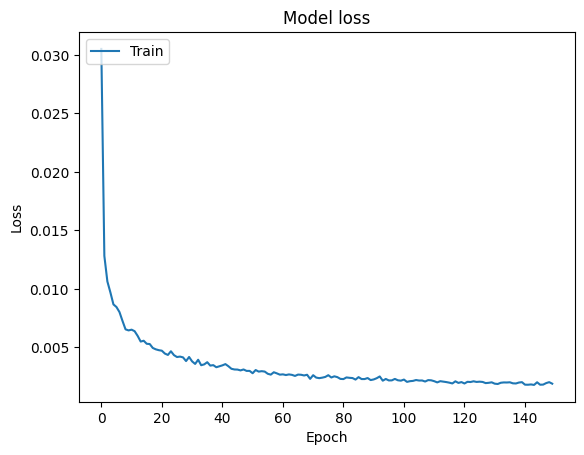

30/30 [==============================] - 1s 6ms/step
R2 Score: 0.9786754474276789


In [12]:
predictions = []

df, last_sequence, x_train, y_train = PrepareDataPredict(1)
print(x_train.shape)

model = GetTrainedModelPredict(x_train, y_train)

In [13]:
last_sequence = last_sequence[-input_lag:]
last_sequence = np.expand_dims(last_sequence, axis=0)

In [14]:
prediction = model.predict(last_sequence)

1/1 [==============================] - 0s 31ms/step


In [15]:
predicted_price = close_scaler.inverse_transform(prediction)[0][0]

predictions.append(round(float(predicted_price), 2))

In [16]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'ETH prediction for upcoming day ({predictions_str})'

  print(message)

ETH prediction for upcoming day (1609.03$)


In [ ]:
copy_df = df_ethereum.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(close_scaler.inverse_transform(y_predicted))
first_seq = close_scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = close_scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
y_predicted_transformed

# Predict more data

In [20]:
data_scaler = MinMaxScaler()
data_scaler.fit(df_ethereum[['Open', 'High', 'Low']])
df_ethereum[['scaled_open', 'scaled_high', 'scaled_low']] = data_scaler.transform(df_ethereum[['Open', 'High', 'Low']])

close_scaler = MinMaxScaler()
close_scaler.fit(df_ethereum[['Close']])
df_ethereum[['scaled_close']] = close_scaler.transform(df_ethereum[['Close']])

feature_scaler = MinMaxScaler()
feature_scaler.fit(df_ethereum[['FAGI', 'RSI', 'MA_50', 'ROC_26']])
df_ethereum[['scaled_fagi', 'scaled_rsi', 'scaled_ma', 'scaled_roc']] = feature_scaler.transform(df_ethereum[['FAGI', 'RSI', 'MA_50', 'ROC_26']])

<ipython-input-20-03fe0588f9ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ethereum[['scaled_open', 'scaled_high', 'scaled_low']] = data_scaler.transform(df_ethereum[['Open', 'High', 'Low']])
<ipython-input-20-03fe0588f9ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ethereum[['scaled_open', 'scaled_high', 'scaled_low']] = data_scaler.transform(df_ethereum[['Open', 'High', 'Low']])
<ipython-input-20-03fe0588f9ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [ ]:
temp_df = df_ethereum.drop(['Date', 'Open', 'Close', 'High', 'Low', 'RSI', 'FAGI', 'MA_50', 'ROC_26'], axis=1)
correlation_matrix = temp_df.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [22]:
def PrepareDataPredict(days):
  df = df_ethereum.copy()
  df['target'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close', 'scaled_open', 'scaled_high', 'scaled_low', 'scaled_rsi', 'scaled_fagi', 'scaled_ma', 'scaled_roc']].tail(days))
  df.dropna(inplace=True)

  data_for_sequences = []
  sequences = deque(maxlen=input_lag)

  for entry, target in zip(df[['scaled_close', 'scaled_open', 'scaled_high', 'scaled_low', 'scaled_rsi', 'scaled_fagi', 'scaled_ma', 'scaled_roc']].values, df['target'].values):
    sequences.append(entry)
    if len(sequences) == input_lag:
        data_for_sequences.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close', 'scaled_open', 'scaled_high', 'scaled_low', 'scaled_rsi', 'scaled_fagi', 'scaled_ma', 'scaled_roc'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  X, Y = [], []
  for seq, target in data_for_sequences:
      X.append(seq)
      Y.append(target)

  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [23]:
def GetTrainedModelPredict(x_train, y_train):

  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(input_lag, 8),  kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=False,  kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 2
  EPOCHS = 150

  optimizer = Adam(learning_rate=0.0001)

  model.compile(loss='mean_squared_error', optimizer=optimizer)

  history = model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  plt.plot(history.history['loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

  y_pred = model.predict(x_train)
  print('R2 Score:', r2_score(y_train, y_pred))

  return model

(937, 14, 8)
Epoch 1/150
469/469 [==============================] - 11s 14ms/step - loss: 0.0170
Epoch 2/150
469/469 [==============================] - 8s 17ms/step - loss: 0.0120
Epoch 3/150
469/469 [==============================] - 7s 14ms/step - loss: 0.0110
Epoch 4/150
469/469 [==============================] - 9s 18ms/step - loss: 0.0103
Epoch 5/150
469/469 [==============================] - 7s 14ms/step - loss: 0.0095
Epoch 6/150
469/469 [==============================] - 9s 20ms/step - loss: 0.0086
Epoch 7/150
469/469 [==============================] - 8s 16ms/step - loss: 0.0082
Epoch 8/150
469/469 [==============================] - 10s 21ms/step - loss: 0.0073
Epoch 9/150
469/469 [==============================] - 6s 14ms/step - loss: 0.0075
Epoch 10/150
469/469 [==============================] - 8s 18ms/step - loss: 0.0076
Epoch 11/150
469/469 [==============================] - 7s 14ms/step - loss: 0.0066
Epoch 12/150
469/469 [==============================] - 8s 18ms/step -

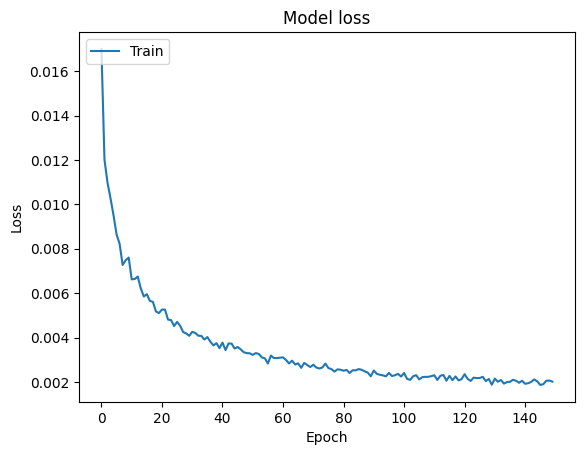

30/30 [==============================] - 2s 8ms/step
R2 Score: 0.9820789022988147


In [24]:
predictions = []

df, last_sequence, x_train, y_train = PrepareDataPredict(1)
print(x_train.shape)

model = GetTrainedModelPredict(x_train, y_train)

In [25]:
last_sequence = last_sequence[-input_lag:]
last_sequence = np.expand_dims(last_sequence, axis=0)

In [26]:
prediction = model.predict(last_sequence)

1/1 [==============================] - 0s 28ms/step


In [27]:
predicted_price = close_scaler.inverse_transform(prediction)[0][0]

predictions.append(round(float(predicted_price), 2))

In [28]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'ETH prediction for upcoming day ({predictions_str})'

  print(message)

ETH prediction for upcoming day (1650.38$)


# Metrics

In [25]:
data_scaler = MinMaxScaler()
data_scaler.fit(df_ethereum[['Open', 'High', 'Low']])
df_ethereum[['scaled_open', 'scaled_high', 'scaled_low']] = data_scaler.transform(df_ethereum[['Open', 'High', 'Low']])

close_scaler = MinMaxScaler()
close_scaler.fit(df_ethereum[['Close']])
df_ethereum[['scaled_close']] = close_scaler.transform(df_ethereum[['Close']])

feature_scaler = MinMaxScaler()
feature_scaler.fit(df_ethereum[['FAGI', 'RSI']])
df_ethereum[['scaled_fagi', 'scaled_rsi']] = feature_scaler.transform(df_ethereum[['FAGI', 'RSI']])

<ipython-input-25-f6e162e65e00>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ethereum[['scaled_open', 'scaled_high', 'scaled_low']] = data_scaler.transform(df_ethereum[['Open', 'High', 'Low']])
<ipython-input-25-f6e162e65e00>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ethereum[['scaled_open', 'scaled_high', 'scaled_low']] = data_scaler.transform(df_ethereum[['Open', 'High', 'Low']])
<ipython-input-25-f6e162e65e00>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [26]:
def PrepareDataValidate(days):
  df = df_ethereum.copy()
  df['target'] = df['scaled_close'].shift(-days)
  df.dropna(inplace=True)

  data_for_sequences = []
  sequences = deque(maxlen=input_lag)

  for entry, target in zip(df[['scaled_close', 'scaled_rsi', 'scaled_fagi']].values, df['target'].values):
    sequences.append(entry)
    if len(sequences) == input_lag:
        data_for_sequences.append([np.array(sequences), target])

  X, Y = [], []
  for seq, target in data_for_sequences:
      X.append(seq)
      Y.append(target)

  X = np.array(X)
  Y = np.array(Y)

  train_size = int(0.8 * len(X))
  X_train, X_val = X[:train_size], X[train_size:]
  y_train, y_val = Y[:train_size], Y[train_size:]


  return X_train, y_train, X_val, y_val

In [27]:
def GetTrainedModelMetrics(x_train, y_train, x_val, y_val):
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(input_lag, 3),  kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=False,  kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 2
  EPOCHS = 150

  optimizer = Adam(learning_rate=0.0001)

  model.compile(loss='mean_squared_error', optimizer=optimizer)

  history = model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            validation_data=(x_val, y_val))

  model.summary()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  y_pred_train = model.predict(x_train)
  print('Train R2 Score:', r2_score(y_train, y_pred_train))

  y_pred_val = model.predict(x_val)
  print('Validation R2 Score:', r2_score(y_val, y_pred_val))

  return model, history

Epoch 1/150
401/401 [==============================] - 16s 21ms/step - loss: 0.0271 - val_loss: 0.0106
Epoch 2/150
401/401 [==============================] - 5s 12ms/step - loss: 0.0149 - val_loss: 0.0086
Epoch 3/150
401/401 [==============================] - 6s 15ms/step - loss: 0.0125 - val_loss: 0.0073
Epoch 4/150
401/401 [==============================] - 5s 12ms/step - loss: 0.0115 - val_loss: 0.0064
Epoch 5/150
401/401 [==============================] - 5s 13ms/step - loss: 0.0101 - val_loss: 0.0060
Epoch 6/150
401/401 [==============================] - 5s 13ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 7/150
401/401 [==============================] - 5s 12ms/step - loss: 0.0084 - val_loss: 0.0047
Epoch 8/150
401/401 [==============================] - 5s 14ms/step - loss: 0.0078 - val_loss: 0.0045
Epoch 9/150
401/401 [==============================] - 5s 12ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 10/150
401/401 [==============================] - 5s 13ms/step - loss: 0.00

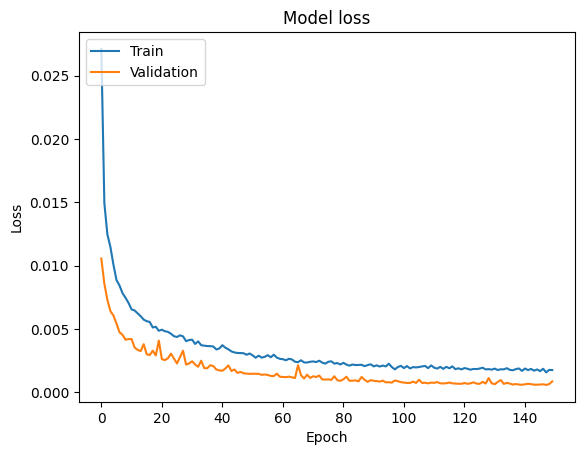

26/26 [==============================] - 1s 5ms/step
Train R2 Score: 0.9790331152124369
7/7 [==============================] - 0s 6ms/step
Validation R2 Score: 0.9189265710005424


In [28]:
x_train, y_train, x_val, y_val = PrepareDataValidate(1)

model, history = GetTrainedModelMetrics(x_train, y_train, x_val, y_val)

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate the predicted probabilities
y_pred_proba = model.predict(x_val).ravel()

# Calculate the AUC
auc = roc_auc_score(y_val, y_pred_proba)

print('AUC: ', auc)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

7/7 [==============================] - 0s 7ms/step


ValueError: continuous format is not supported

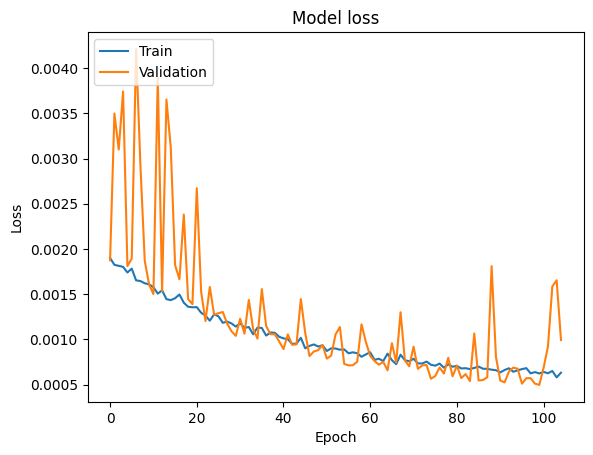

In [22]:
cut_off_index = int(len(history.history['loss']) * 0.3)

# Plot the loss history, starting from the cut-off index
plt.plot(history.history['loss'][cut_off_index:])
plt.plot(history.history['val_loss'][cut_off_index:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()